<a href="https://colab.research.google.com/github/myazdani/hacking-minGPT/blob/main/play_seq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hacking minGPT with a toy sequential task

François Fleuret came up with a toy sequential task to get better intuition with attention layers. Here I'll take the GPT architecture (minGPT by Andrej Karpathy specifically) to (sorta) solve the task. 

The task is summarized by this slide from François' deep learning course EE-559: 

<div>
<img src="https://i.imgur.com/ez02xV9.png" width="700"/>
</div>

- the input: pairs of triangle and rectangle shapes at different heights. 
- the desired output: have the same shapes but each pair needs to have the same average height. 


<div>
<img src="https://i.imgur.com/zDHnv7B.png" width="700"/>
</div>

For example, the output two triangle pairs both need to have the same height and this height needs to be the average height of the short and tall traingle pairs in the inputs.

In [1]:
## only needed if running on google colab
!git clone https://github.com/myazdani/hacking-minGPT.git

import sys
  
# adding Folder_2 to the system path
sys.path.insert(0, './hacking-minGPT/')


!wget https://raw.githubusercontent.com/myazdani/attention-layer-demo/master/utils.py

Cloning into 'hacking-minGPT'...
remote: Enumerating objects: 110, done.
remote: Counting objects: 100% (110/110), done.
remote: Compressing objects: 100% (77/77), done.
remote: Total 110 (delta 69), reused 66 (delta 31), pack-reused 0
Receiving objects: 100% (110/110), 1.10 MiB | 7.02 MiB/s, done.
Resolving deltas: 100% (69/69), done.
--2022-07-13 04:49:50--  https://raw.githubusercontent.com/myazdani/attention-layer-demo/master/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3583 (3.5K) [text/plain]
Saving to: ‘utils.py’

utils.py            100%[===================>]   3.50K  --.-KB/s    in 0s      

2022-07-13 04:49:51 (53.5 MB/s) - ‘utils.py’ saved [3583/3583]



## get the data

In [2]:
# make deterministic
import numpy as np
import torch
import torch.nn as nn
from torch.nn import functional as F
import matplotlib.pyplot as plt
from mingpt.utils import set_seed
set_seed(42)
import utils as seq_utils

data_gen = seq_utils.DataUtil(seq_height_min = 1.0, 
                          seq_height_max = 25.0,
                          seq_width_min = 5.0, 
                          seq_width_max = 11.0,
                          seq_length = 100,
                          group_by_locations = False
                         )

In [3]:
train_input, train_targets, train_tr, train_bx = data_gen.generate_sequences(25000)
test_input, test_targets, test_tr, test_bx = data_gen.generate_sequences(1000)

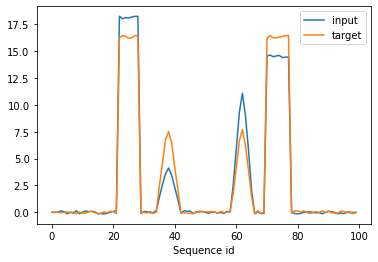

In [4]:
plt.plot(train_input[1,0,:], label = "input")
plt.plot(train_targets[1,0,:], label = "target")
plt.xlabel("Sequence id")
plt.legend();

### cluster the raw sequence values into discrete clusters

Since the input of the minGPT needs to be discrete, I discretize with K-means. Karpathy does similar for applying minGPT to CIFAR images. 

In [5]:
# get random 5 vals per seq and stack them all up 
pluck_vals = lambda x: x[0,torch.randperm(100)[:5]]
random_vals = torch.cat([pluck_vals(x) for x in train_input]).numpy()
print(random_vals.shape)

(125000,)


In [6]:
from sklearn.cluster import KMeans
num_clusters = 256
kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(random_vals[:,np.newaxis])
kmeans.labels_

array([216, 209, 255, ...,  71, 228,  96], dtype=int32)

## Wrap discretizes sequences into a dataloader

In [7]:
from torch.utils.data import Dataset

class SeqDataset(Dataset):
    """
    wrap up seq dataset into our own, which will convert floating points into sequences of integers
    """
    
    def __init__(self, inputs, targets, kmeans_clusters):
        self.inputs = inputs
        self.targets = targets
        self.kmeans_clusters = kmeans_clusters
        
    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        x, y = self.inputs[idx], self.targets[idx]
        batch_size = x.shape[0]
        x_np = x.view(-1,1).numpy()
        y_np = y.view(-1,1).numpy()
        x_clusters = torch.from_numpy(self.kmeans_clusters.predict(x_np)).view(batch_size,-1).long()
        y_clusters = torch.from_numpy(self.kmeans_clusters.predict(y_np)).view(batch_size,-1).long()

        return x_clusters.squeeze(), y_clusters.squeeze()

In [8]:
train_dataset = SeqDataset(train_input, train_targets, kmeans)
test_dataset = SeqDataset(test_input, test_targets, kmeans)
train_dataset[0][0] # one example sequence flattened out into integers

tensor([ 80, 117,  49, 246,  32, 124, 255,  80, 178,   0, 117, 216, 117,   0,
          0, 228, 156,  95, 241,  95, 156, 241,  96, 246, 206,   5,  77, 191,
        163, 106, 115, 170, 113, 232, 231, 176,  96, 178, 216,  80,  80, 110,
         86,  50, 159, 137, 148, 144, 188,  75, 255,  32, 176,  32, 117, 180,
         32, 216,  71,  49,  14,  80, 255, 178,   0,  80, 255, 178,  83, 209,
         83, 223, 209, 133, 133, 124, 216, 246, 228, 167, 178, 176,  14, 216,
        180, 180,  71, 178,  71,  49, 167, 176,  49,  14, 117,  96, 117,  49,
         14, 246])

# GPT training

mostly using paramters used for CIFAR; might be a bit overkill?

In [9]:
from mingpt.model import GPT, GPTConfig
block_size = 100
mconf = GPTConfig(num_clusters, block_size,
                  embd_pdrop=0.0, resid_pdrop=0.0, attn_pdrop=0.0,
                  n_layer=12, n_head=8, n_embd=256)
model = GPT(mconf)


In [10]:
from mingpt.trainer import Trainer, TrainerConfig

# initialize a trainer instance and kick off training
# kinda guessing these
tconf = TrainerConfig(max_epochs=10, batch_size=256, learning_rate=1e-4,
                      lr_decay=True, warmup_tokens=1024, 
                      num_workers=2)

trainer = Trainer(model, train_dataset, None, tconf)
trainer.train()

epoch 1 iter 97: train loss 3.76646. lr 1.000000e-04: 100%|██████████| 98/98 [00:44<00:00,  2.18it/s]
epoch 2 iter 97: train loss 3.52670. lr 1.000000e-04: 100%|██████████| 98/98 [00:42<00:00,  2.32it/s]
epoch 3 iter 97: train loss 3.46497. lr 1.000000e-04: 100%|██████████| 98/98 [00:41<00:00,  2.34it/s]
epoch 4 iter 97: train loss 3.38630. lr 1.000000e-04: 100%|██████████| 98/98 [00:42<00:00,  2.33it/s]
epoch 5 iter 97: train loss 3.32625. lr 1.000000e-04: 100%|██████████| 98/98 [00:42<00:00,  2.33it/s]
epoch 6 iter 97: train loss 3.27124. lr 1.000000e-04: 100%|██████████| 98/98 [00:42<00:00,  2.33it/s]
epoch 7 iter 97: train loss 3.21525. lr 1.000000e-04: 100%|██████████| 98/98 [00:41<00:00,  2.33it/s]
epoch 8 iter 97: train loss 3.17643. lr 1.000000e-04: 100%|██████████| 98/98 [00:42<00:00,  2.32it/s]
epoch 9 iter 97: train loss 3.14479. lr 1.000000e-04: 100%|██████████| 98/98 [00:42<00:00,  2.33it/s]
epoch 10 iter 97: train loss 3.11946. lr 1.000000e-04: 100%|██████████| 98/98 [00:

In [11]:
def compare_predictions(example_pair):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    pred = model(example_pair[0].view(1,-1).to(device))

    # inverse kmeans transform the inputs, predictions, and outputs
    raw_input = kmeans.cluster_centers_[:,0][example_pair[0].cpu().numpy()]
    raw_pred = kmeans.cluster_centers_[:,0][pred[0].argmax(axis=2).cpu().numpy().squeeze()]
    raw_output = kmeans.cluster_centers_[:,0][example_pair[1].cpu().numpy()]
    plt.plot(raw_input, label = 'input')
    plt.plot(raw_pred, label = 'pred target')
    plt.plot(raw_output, label = 'actual target')
    plt.legend();

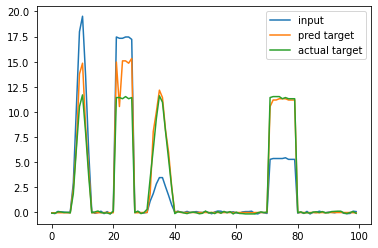

In [12]:
compare_predictions(test_dataset[0])

In [25]:
# looks like we need some more training iterations..